# Looks at correlations between dataset characteristics and percent error
NOTE: for future work with functions related to get_set_splits(), might want to update them in a separate file. See dataset_splitting_functions.py

I think a better focus would be targeting and improving specific trip level mode errors eg ebike misclassified as car.\
- To see specific mmisprediction rates, look at the cells with print_actual_percents_given_prediction() and print_prediction_percents_given_actual. I think the latter is more important.
- It might be useful to make a confusion matrix based on CanBikeCO data and compare it with the mobilitynet confusion matrices.

Split datasets into subsets to get different shares of modes \
Calculate subset wide characteristics (eg, proportion of trips that use a car/taxi).\
Are these characteristics correlated with the percent error for expected value based on the sensed modes?

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import get_EC
import helper_functions as hf

import sklearn.model_selection as skm

from sklearn.model_selection import KFold
from sklearn import linear_model

import scipy

from itertools import chain

METERS_TO_MILES = 0.000621371 # 1 meter = 0.000621371 miles
ECAR_PROPORTION = 0 #0.01 #~1% of cars on the road are electric.
DROVE_ALONE_TO_SHARED_RIDE_RATIO = 1

df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv') # r stands for raw string, only matters if the path is on Windows

In [2]:
# If you already ran store_expanded_labeled_trips.ipynb already and want to save time vs running the cell below
%store -r expanded_labeled_trips

In [3]:
# Alternatively you could run "Store_expanded_labeled_trips.ipynb" first and then this line.
# %store -r expanded_labeled_trips 

'''import database_related_functions as drf  # all the emission server functions for this notebook are in here.

user_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()

# 6-14 minutes for entire 1.5 year CEO + stage + prepilot
# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.
expanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)
expanded_labeled_trips['os'] = expanded_labeled_trips.user_id.map(os_map)
expanded_labeled_trips['program'] = expanded_labeled_trips['user_id'].map(uuid_program_map)

expanded_labeled_trips = expanded_labeled_trips.drop(labels = ['source', 'end_fmt_time', 'end_loc', 'raw_trip',
    'start_fmt_time', 'start_loc','start_local_dt_year', 'start_local_dt_month', 'start_local_dt_day',
    'start_local_dt_hour', 'start_local_dt_minute', 'start_local_dt_second',
    'start_local_dt_weekday', 'start_local_dt_timezone',
    'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
    'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
    'end_local_dt_weekday', 'end_local_dt_timezone'], axis = 1)

expanded_labeled_trips['distance_miles'] = expanded_labeled_trips.distance*METERS_TO_MILES

# Group together the prepilot participants
prepilot_list = ['84Q9SsrH','cwZazZLJ','CudLAeg8','sxxcLqbK','Q8T7QTXK','5KEGHHuf','e9MaNVU7','7c797MRD','rhBZukxY','k36cxmfA','FmxVf8u6','F3jxHLSW']
expanded_labeled_trips['program'] = expanded_labeled_trips.program.replace(prepilot_list, "prepilot")'''

'import database_related_functions as drf  # all the emission server functions for this notebook are in here.\n\nuser_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()\n\n# 6-14 minutes for entire 1.5 year CEO + stage + prepilot\n# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.\nexpanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)\nexpanded_labeled_trips[\'os\'] = expanded_labeled_trips.user_id.map(os_map)\nexpanded_labeled_trips[\'program\'] = expanded_labeled_trips[\'user_id\'].map(uuid_program_map)\n\nexpanded_labeled_trips = expanded_labeled_trips.drop(labels = [\'source\', \'end_fmt_time\', \'end_loc\', \'raw_trip\',\n    \'start_fmt_time\', \'start_loc\',\'start_local_dt_year\', \'start_local_dt_month\', \'start_local_dt_day\',\n    \'start_local_dt_hour\', \'start_local_dt_minute\', \'start_local_dt_second\',\n    \'start_local_dt_weekday\', \'start_local_dt_timezone\',\n    \'end_local_dt_year\

In [4]:
unit_dist_MCS_df = pd.read_csv("unit_distance_MCS.csv").set_index("moment")
energy_dict = cm_handling.get_energy_dict(df_EI)

In [5]:
# Drop trips you want to exclude from analysis.
expanded_labeled_trips = hf.drop_unwanted_trips(expanded_labeled_trips,drop_not_a_trip=False)

# Find the primary mode - the sensed mode with the longest section for each trip.
expanded_labeled_trips = hf.get_primary_modes(expanded_labeled_trips,energy_dict,MODE_MAPPING_DICT)

print('Here are the number of labeled trips remaining in each program dataset:')
expanded_labeled_trips.program.value_counts()

Dropping user labeled AIR trips and trips with no OS.
Dropped 93 trips with no sensed sections.
Here are the number of labeled trips remaining in each program dataset:


cc          28768
pc          17880
fc          11744
stage       10715
sc           9092
vail         6348
4c           5262
prepilot     2425
Name: program, dtype: int64

In [6]:
# Look at the proportions of each mode that were sensed
sensed_mode_distance_map = {}
for _,ct in expanded_labeled_trips.iterrows():
    sections_lengths = np.array(ct["section_distances"])*METERS_TO_MILES 
    for i, mode in enumerate(ct["section_modes"]):
        if mode not in sensed_mode_distance_map.keys():
            sensed_mode_distance_map[mode] = 0
        # Add to the total distance traveled in this mode.
        sensed_mode_distance_map[mode] += sections_lengths[i]
{x: sensed_mode_distance_map[x]/sum(sensed_mode_distance_map.values()) for x in sensed_mode_distance_map}

{'bicycling': 0.07369370712933099,
 'walking': 0.06126433729997695,
 'car': 0.768106621953594,
 'bus': 0.0029946422293117532,
 'no_sensed': 0.04626239543074133,
 'air_or_hsr': 0.0423027972352415,
 'train': 0.00455116607339093,
 'subway': 0.000824332648412599}

In [7]:
# Get the confusion matrices and then the EI moments from those.
android_confusion = pd.read_csv("android_confusion.csv").set_index('gt_mode')
ios_confusion = pd.read_csv("ios_confusion.csv").set_index('gt_mode')

android_confusion = cm_handling.collapse_confusion_matrix(android_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})
ios_confusion = cm_handling.collapse_confusion_matrix(ios_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})

# here I'm referring to car_load_factor the number that we divide the drove alone energy intensity by
# for r = 1, car_load_factor is 4/3.
sensed_car_EI = hf.find_sensed_car_energy_intensity(energy_dict, ECAR_PROPORTION, DROVE_ALONE_TO_SHARED_RIDE_RATIO)
energy_dict.update({"Car, sensed": sensed_car_EI})
expanded_labeled_trips['distance_miles'] = expanded_labeled_trips.distance*METERS_TO_MILES
EI_length_cov = 0

In [8]:
# calculate the energy consumption for each trip before shuffling and splitting.
android_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(android_confusion,energy_dict)
ios_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(ios_confusion,energy_dict)
os_EI_moments_map = {'ios': ios_EI_moments_df, 'android': android_EI_moments_df}
energy_consumption_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,android_EI_moments_df,ios_EI_moments_df,
    EI_length_cov, print_info=False)

Computing energy consumption for each trip.
Using EI length covariance = 0.


In [9]:
# This shows the frequency of actual labels occuring for each predicted label
def print_actual_percents_given_prediction(df,main_mode_confirms, which_primary_modes):
    df = df[df['mode_confirm'].isin(main_mode_confirms)].copy()
    for mode in which_primary_modes:
        mode_df = df[df['primary_mode'] == mode]

        print(mode)
        #print(mode_df.primary_mode.value_counts(normalize=True)) # prediction percentages by mode count

        print(mode_df.groupby('mode_confirm').sum().distance/mode_df.distance.sum()) 

main_mode_confirms = ['drove_alone','shared_ride','walk','pilot_ebike','bus','bike','train','taxi','free_shuttle', 'not_a_trip']

print('ios')
print_actual_percents_given_prediction(expanded_labeled_trips[expanded_labeled_trips.os == 'ios'].copy(),main_mode_confirms, which_primary_modes= ['bus'])

print('android')
print_actual_percents_given_prediction(expanded_labeled_trips[expanded_labeled_trips.os == 'android'].copy(),main_mode_confirms, which_primary_modes= ['bus'])

ios
bus
mode_confirm
bike           0.021015
bus            0.285425
drove_alone    0.162128
pilot_ebike    0.059709
shared_ride    0.360676
taxi           0.028974
walk           0.082073
Name: distance, dtype: float64
android
bus
mode_confirm
bike            0.003405
bus             0.188068
drove_alone     0.304515
free_shuttle    0.000649
not_a_trip      0.019117
pilot_ebike     0.061308
shared_ride     0.347892
taxi            0.004386
train           0.025852
walk            0.044809
Name: distance, dtype: float64


In [10]:
# This shows the frequency of predicted labels occuring for each actual label
def print_prediction_percents_given_actual(df,main_mode_confirms, which_actual_modes):
    df = df[df['mode_confirm'].isin(main_mode_confirms)].copy()
    for mode in which_actual_modes:
        mode_df = df[df['mode_confirm'] == mode]

        print(mode)
        #print(mode_df.primary_mode.value_counts(normalize=True)) # prediction percentages by mode count

        print(mode_df.groupby('primary_mode').sum().distance/mode_df.distance.sum()) 

main_mode_confirms = ['drove_alone','shared_ride','walk','pilot_ebike','bus','bike','train','taxi','free_shuttle', 'not_a_trip']

print('ios')
print_prediction_percents_given_actual(expanded_labeled_trips[expanded_labeled_trips.os == 'ios'].copy(),main_mode_confirms, which_actual_modes= ['pilot_ebike'])

print('android')
print_prediction_percents_given_actual(expanded_labeled_trips[expanded_labeled_trips.os == 'android'].copy(),main_mode_confirms, which_actual_modes= ['pilot_ebike'])

ios
pilot_ebike
primary_mode
air_or_hsr    0.002560
bicycling     0.341669
bus           0.000683
car           0.440319
no_sensed     0.042430
train         0.000837
walking       0.171501
Name: distance, dtype: float64
android
pilot_ebike
primary_mode
air_or_hsr    0.000007
bicycling     0.415460
bus           0.002169
car           0.391517
no_sensed     0.039732
train         0.005735
walking       0.145380
Name: distance, dtype: float64


### What factors contribute to the error?
NOTE: for future work with the get_set_splits and related functions, might want to update them in a separate file. See dataset_splitting_functions.py

In [11]:
# randomly split CEO dataset many times.
# compute the factors for each split.
# compute the error.
# compute the correlation.

IND_VAR = ['drove_alone_2_shared_ride', 'no_sensed_ratio', 'car_like_ratio', 'e_bike_ratio', 'not_a_trip_ratio',
           "car_like_as_not_car", "e_bike_as_car", "e_bike_as_not_car_bike", 
           "non_car_2_car_user_label", "mispredicted_as_walk", "mispredicted_as_car", 'distance_miles']
DEP_VAR = 'error_pct_for_confusion'

In [12]:
# There are multiple crossvalidation splitters in sklearn but all of them split into one training and one test set at a time
# If you get this error: "object of type 'int' has no len()", just lower the number of splits per round
def get_set_splits(df, n_rounds = 50, n_splits_per_round=10):
    '''
    Splits data into n_rounds * n_splits_per_round sets.
    n_splits_per_round controls the size of the resulting data subsets. 
    To get lots of datasets without shrinking the size too much, we use multiple rounds of splits.

    Returns numpy array of arrays of data indices.
    '''
    df = df.copy()
    from numpy.random import default_rng
    large_size_splits = []
    for round in range(n_rounds):
        rng = default_rng()
        trip_index = np.array(df.index.copy())
        rng.shuffle(trip_index)
        # print(energy_consumption_df.index, trip_index)

        # splits is a list of numpy arrays of trip indices
        splits = np.array_split(trip_index, n_splits_per_round)

        large_size_splits.append(splits)
    
    unnested_large_size_splits = list(chain.from_iterable(large_size_splits))
    print(f"Subset lengths: {len(unnested_large_size_splits[0])}. Number of subsets: {len(unnested_large_size_splits)}")
    #print([len(s) for s in large_size_splits])

    return unnested_large_size_splits

In [13]:
# Several of the split results appear normally distributed about the mean of whatever the dataset used to generate the splits was.
def get_split_results(splits):
    
    CAR_LIKE_MODES = ['drove_alone', 'shared_ride', 'taxi']
    NON_CAR_MOTORIZED_MODES = ['bus', 'free_shuttle', 'train']
    split_result_list = []
    for s in splits:
        ERROR_COLS = ['error_for_confusion',
           'error_for_prediction', 'expected', 'predicted', 'user_labeled', 'distance_miles', 'distance', 'duration']
        curr_split_trips = energy_consumption_df.loc[s]
        curr_split_result = {'count': len(s)}
        for e in ERROR_COLS:
            curr_split_result[e] = curr_split_trips[e].sum()
        curr_split_result['drove_alone_2_shared_ride'] = curr_split_trips.query('mode_confirm == "drove_alone"').distance.sum() / curr_split_trips.query('mode_confirm == "shared_ride"').distance.sum()
        curr_split_result['no_sensed_ratio'] = curr_split_trips.query('primary_mode == "no_sensed"').distance.sum() / curr_split_trips.distance.sum()
        curr_split_result['car_like_ratio'] = curr_split_trips.query('mode_confirm == @CAR_LIKE_MODES').distance.sum() / curr_split_trips.distance.sum()        
        curr_split_result['e_bike_ratio'] = curr_split_trips.query('mode_confirm == "pilot_ebike"').distance.sum() / curr_split_trips.distance.sum()
        curr_split_result['not_a_trip_ratio'] = curr_split_trips.query('mode_confirm == "not_a_trip"').distance.sum() / curr_split_trips.distance.sum()
        
        # car_like_as_not_car: the fraction of car trips that were wrongly labeled as not car. 
        curr_split_result['car_like_as_not_car'] = curr_split_trips.query('mode_confirm == @CAR_LIKE_MODES & primary_mode != "car"').distance.sum() / curr_split_trips.query('mode_confirm == @CAR_LIKE_MODES').distance.sum()
        curr_split_result['e_bike_as_car'] = curr_split_trips.query('mode_confirm == "pilot_ebike" & primary_mode == "car"').distance.sum() / curr_split_trips.query('mode_confirm == "pilot_ebike"').distance.sum()
        curr_split_result['e_bike_as_not_car_bike'] = curr_split_trips.query('mode_confirm == "pilot_ebike" & primary_mode != ["car", "bicycling"]').distance.sum() / curr_split_trips.query('mode_confirm == "pilot_ebike"').distance.sum()

        curr_split_result['non_car_2_car_user_label'] = curr_split_trips.query('mode_confirm == @NON_CAR_MOTORIZED_MODES').distance.sum() / curr_split_trips.query('mode_confirm == @CAR_LIKE_MODES').distance.sum()
        curr_split_result['non_car_2_car_sensed'] = curr_split_trips.query('primary_mode == ["bus", "train"]').distance.sum() / curr_split_trips.query('primary_mode == "car"').distance.sum()
        curr_split_result['mispredicted_as_walk'] = curr_split_trips.query('mode_confirm != "walk" & primary_mode == "walking"').distance.sum() / curr_split_trips.distance.sum()
        curr_split_result['mispredicted_as_car'] = curr_split_trips.query('mode_confirm != @CAR_LIKE_MODES & primary_mode == "car"').distance.sum() / curr_split_trips.distance.sum()
    
        # if curr_split_result['drove_alone_2_shared_ride'] > 0.5:
            # print(f"CHECK: drove_alone %s, shared_ride %s" % (curr_split_trips.query('mode_confirm == "drove_alone"').distance_miles.sum(),
            #                                                   curr_split_trips.query('mode_confirm == "shared_ride"').distance_miles.sum()))
        # print(curr_split_result)
        # print(f"CHECK user_labeled {energy_consumption_df.loc[s].user_labeled.sum()}")
        # print(f"CHECK error_for_confusion {energy_consumption_df.loc[s].error_for_confusion.sum()}")
        split_result_list.append(curr_split_result)
    split_results = pd.DataFrame(split_result_list)
    split_results['error_pct_for_confusion'] = (split_results.error_for_confusion / split_results.user_labeled ) * 100
    split_results['error_pct_for_prediction'] = (split_results.error_for_prediction / split_results.user_labeled) * 100
    return split_results

Subset lengths: 9224. Number of subsets: 500


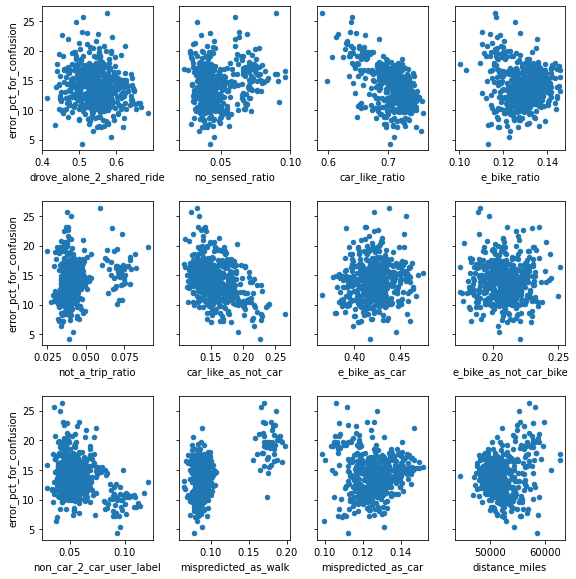

In [14]:
# This cell finds the correlation between the independent variables and the dependent variable. 
# It also makes scatterplots of the dependent variable vs each independent variable.
splits = get_set_splits(energy_consumption_df)
split_results = get_split_results(splits)
fig, ax2d = plt.subplots(nrows=3, ncols=4, figsize=(8,8), sharey=True)
fig.tight_layout(h_pad = 3)
axarray = ax2d.flatten()
IND_VAR = ['drove_alone_2_shared_ride', 'no_sensed_ratio', 'car_like_ratio', 'e_bike_ratio', 'not_a_trip_ratio',
           "car_like_as_not_car", "e_bike_as_car", "e_bike_as_not_car_bike", 
           "non_car_2_car_user_label", "mispredicted_as_walk", "mispredicted_as_car", 'distance_miles']
DEP_VAR = 'error_pct_for_confusion'

ind_var_correlation_map = {}
ind_var_correlation_df = pd.DataFrame(columns=["Independent Variable", "Correlation", "p-value"])
for iv, ax in zip(IND_VAR, axarray):
    split_results.plot(x=iv, y=DEP_VAR, ax=ax, kind="scatter")

    ind_var_correlation_map[iv] = round(split_results[iv].corr(split_results[DEP_VAR]),3)
    corr, p = scipy.stats.pearsonr(split_results[iv],split_results[DEP_VAR])
    
    ind_var_correlation_df = ind_var_correlation_df.append({"Independent Variable": iv, "Correlation": corr, "p-value": p}, ignore_index=True)

In [15]:
def find_correlations(split_results, IND_VAR, DEP_VAR):
    ind_var_correlation_df = pd.DataFrame(columns=["Independent Variable", "Correlation", "p-value"])
    for iv in IND_VAR:
        corr, p = scipy.stats.pearsonr(split_results[iv],split_results[DEP_VAR])
        ind_var_correlation_df = ind_var_correlation_df.append({"Independent Variable": iv, "Correlation": corr, "p-value": p}, ignore_index=True)
    return ind_var_correlation_df.set_index("Independent Variable")

In [16]:
def get_splits_and_correlations(df,n_rounds = 50, n_splits_per_round=10):
    df = df.copy()
    splits = get_set_splits(df, n_rounds, n_splits_per_round)
    split_results = get_split_results(splits)
    ind_var_correlation_df = find_correlations(split_results, IND_VAR, DEP_VAR)
    return ind_var_correlation_df

### Correlations between data characteristics and error

In [17]:
ind_var_correlation_df_no_update = get_splits_and_correlations(energy_consumption_df)
# based on energy consumption df with no prior.
# it seems that the 
ind_var_correlation_df_no_update.query('`p-value` < 0.01')

Subset lengths: 9224. Number of subsets: 500


,Correlation,p-value
Independent Variable,,
no_sensed_ratio,0.220379,6.464041e-07
car_like_ratio,-0.583509,5.925079e-47
not_a_trip_ratio,0.287944,5.309668e-11
car_like_as_not_car,-0.416390,2.181083e-22
non_car_2_car_user_label,-0.288985,4.494523e-11
mispredicted_as_walk,0.501938,2.882837e-33
distance_miles,0.238268,6.954297e-08


#### As seen in paper

In [18]:
# string replace the underscores
ind_var_correlation_df_no_update = ind_var_correlation_df_no_update.reset_index()
ind_var_correlation_df_no_update['Independent Variable'] = ind_var_correlation_df_no_update['Independent Variable'].str.replace('_',' ')
print(ind_var_correlation_df_no_update.query('`p-value` < 0.01')[["Independent Variable","Correlation"]].round(2).to_latex(index=False))

\begin{tabular}{lr}
\toprule
     Independent Variable &  Correlation \\
\midrule
          no sensed ratio &         0.22 \\
           car like ratio &        -0.58 \\
         not a trip ratio &         0.29 \\
      car like as not car &        -0.42 \\
 non car 2 car user label &        -0.29 \\
     mispredicted as walk &         0.50 \\
           distance miles &         0.24 \\
\bottomrule
\end{tabular}



Old values with p < 0.01 for up to May 2022

           car like ratio &        -0.73 \\
             e bike ratio &        -0.21 \\
      car like as not car &        -0.44 \\
            e bike as car &         0.16 \\
     mispredicted as walk &         0.69 \\
      mispredicted as car &        -0.15 \\
           distance miles &         0.37 \\

In [19]:
ind_var_correlation_df_no_update

,Independent Variable,Correlation,p-value
0,drove alone 2 shared ride,-0.104339,1.961581e-02
1,no sensed ratio,0.220379,6.464041e-07
2,car like ratio,-0.583509,5.925079e-47
3,e bike ratio,-0.076915,8.577742e-02
4,not a trip ratio,0.287944,5.309668e-11
5,car like as not car,-0.416390,2.181083e-22
6,e bike as car,0.096046,3.177305e-02
7,e bike as not car bike,-0.004333,9.230088e-01
8,non car 2 car user label,-0.288985,4.494523e-11
9,mispredicted as walk,0.501938,2.882837e-33


### A look at the correlations under different prior mode distributions
Not super important to think about, given that the correlations above are not stable or useful

In [20]:
# note. Approach differently if the android ground truth modes are not the same set as ios ground truth modes in the test dataset.
available_ground_truth_modes = android_confusion.index
mostly_car_prior = hf.construct_prior_dict({"Car, sensed": 0.80, "Pilot ebike": 0.05}, available_ground_truth_modes)
uniform_prior = hf.construct_prior_dict({}, available_ground_truth_modes)
half_ebike = hf.construct_prior_dict({"Pilot ebike": 0.50}, available_ground_truth_modes)


prior_mode_distributions_map = {"80 Percent Car": mostly_car_prior, "Uniform Prior": uniform_prior, "50 Percent Ebike": half_ebike}
_, prior_and_energy_dataframe_map  = hf.prior_mode_distribution_sensitivity_analysis(expanded_labeled_trips, prior_mode_distributions_map, android_confusion, ios_confusion, unit_dist_MCS_df, energy_dict)

80 Percent Car
Computing energy consumption for each trip.
Using EI length covariance = 0.
Uniform Prior
Computing energy consumption for each trip.
Using EI length covariance = 0.
50 Percent Ebike
Computing energy consumption for each trip.
Using EI length covariance = 0.


In [21]:
# takes about 40 seconds for each "get_splits_and_correlations" on all CEO up to May 2022
ind_var_correlation_df_mostly_car_prior = get_splits_and_correlations(prior_and_energy_dataframe_map["80 Percent Car"])
ind_var_correlation_df_uniform_prior = get_splits_and_correlations(prior_and_energy_dataframe_map["Uniform Prior"])
ind_var_correlation_df_50_percent_ebike = get_splits_and_correlations(prior_and_energy_dataframe_map["50 Percent Ebike"])

Subset lengths: 9224. Number of subsets: 500
Subset lengths: 9224. Number of subsets: 500
Subset lengths: 9224. Number of subsets: 500


In [22]:
ind_var_correlation_df_mostly_car_prior.query('`p-value` < 0.01')

,Correlation,p-value
Independent Variable,,
no_sensed_ratio,0.295079,1.672017e-11
car_like_ratio,-0.606911,1.226404e-51
not_a_trip_ratio,0.352008,4.957673e-16
car_like_as_not_car,-0.415953,2.436134e-22
non_car_2_car_user_label,-0.344728,2.129964e-15
mispredicted_as_walk,0.455659,5.307584e-27
distance_miles,0.173861,9.317406e-05


In [23]:
ind_var_correlation_df_uniform_prior

,Correlation,p-value
Independent Variable,,
drove_alone_2_shared_ride,-0.052936,2.373815e-01
no_sensed_ratio,0.189363,2.023133e-05
car_like_ratio,-0.610542,2.121302e-52
e_bike_ratio,-0.113543,1.106097e-02
not_a_trip_ratio,0.276880,2.990168e-10
car_like_as_not_car,-0.428461,9.639921e-24
e_bike_as_car,0.006302,8.882061e-01
e_bike_as_not_car_bike,0.025124,5.751599e-01
non_car_2_car_user_label,-0.312970,7.986259e-13


In [24]:
ind_var_correlation_df_uniform_prior.query('`p-value` < 0.01')

,Correlation,p-value
Independent Variable,,
no_sensed_ratio,0.189363,2.023133e-05
car_like_ratio,-0.610542,2.121302e-52
not_a_trip_ratio,0.276880,2.990168e-10
car_like_as_not_car,-0.428461,9.639921e-24
non_car_2_car_user_label,-0.312970,7.986259e-13
mispredicted_as_walk,0.546805,2.498979e-40
distance_miles,0.215557,1.143093e-06


In [25]:
vail_correlations = get_splits_and_correlations(energy_consumption_df.query('program == "vail"'))

Subset lengths: 635. Number of subsets: 500


In [26]:
vail_correlations#.query('`p-value` < 0.01')

,Correlation,p-value
Independent Variable,,
drove_alone_2_shared_ride,-0.300845,6.417368e-12
no_sensed_ratio,0.703888,5.322601e-76
car_like_ratio,-0.768250,1.568385e-98
e_bike_ratio,-0.410641,9.220851e-22
not_a_trip_ratio,0.877693,3.293689e-161
car_like_as_not_car,-0.097681,2.896484e-02
e_bike_as_car,0.020224,6.518877e-01
e_bike_as_not_car_bike,-0.031351,4.842771e-01
non_car_2_car_user_label,0.031274,4.853412e-01


In [27]:
vail_split_results = get_split_results(get_set_splits(energy_consumption_df.query('program == "vail"')))

Subset lengths: 635. Number of subsets: 500


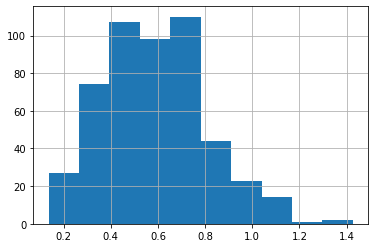

In [28]:
vail_split_results.drove_alone_2_shared_ride.hist()  # the range of values represented in vail is different than that found in all_ceo

Subset lengths: 9224. Number of subsets: 500
Subset lengths: 2235. Number of subsets: 320


Text(0.5, 1.0, 'Based on splits of all pc')

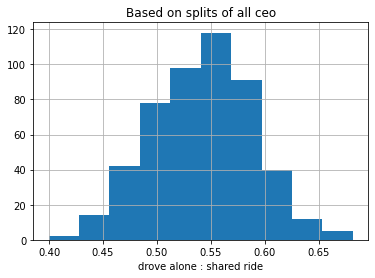

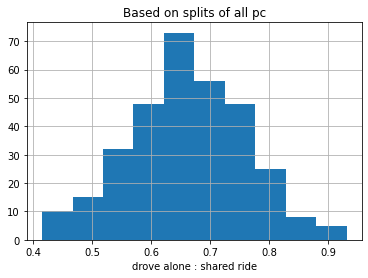

In [29]:
all_ceo_split_results = get_split_results(get_set_splits(energy_consumption_df))
all_ceo_split_results.drove_alone_2_shared_ride.hist()
plt.xlabel("drove alone : shared ride")
plt.title("Based on splits of all ceo")
plt.figure()
pc_split_results = get_split_results(get_set_splits(energy_consumption_df.query('program == "pc"'), n_rounds=40, n_splits_per_round=8))
pc_split_results.drove_alone_2_shared_ride.hist()
plt.xlabel("drove alone : shared ride")
plt.title("Based on splits of all pc")

In [30]:
find_correlations(all_ceo_split_results, IND_VAR, DEP_VAR)

,Correlation,p-value
Independent Variable,,
drove_alone_2_shared_ride,-0.021326,6.342671e-01
no_sensed_ratio,0.230590,1.851544e-07
car_like_ratio,-0.606413,1.557401e-51
e_bike_ratio,-0.090870,4.225106e-02
not_a_trip_ratio,0.293560,2.144119e-11
car_like_as_not_car,-0.391755,8.672592e-20
e_bike_as_car,0.040299,3.685392e-01
e_bike_as_not_car_bike,-0.054076,2.274192e-01
non_car_2_car_user_label,-0.310654,1.198029e-12


In [31]:
pc_corrs = find_correlations(pc_split_results, IND_VAR, DEP_VAR)
pc_corrs

# Note that with no Baye's update the ebike ratio's correlation with the error was ~ -0.25 for all ceo splits but 0.25 for pc splits

,Correlation,p-value
Independent Variable,,
drove_alone_2_shared_ride,-0.081561,1.454703e-01
no_sensed_ratio,0.042841,4.450423e-01
car_like_ratio,0.271581,8.131712e-07
e_bike_ratio,0.483391,3.838118e-20
not_a_trip_ratio,0.584861,9.379063e-31
car_like_as_not_car,-0.296983,6.147530e-08
e_bike_as_car,0.186198,8.166621e-04
e_bike_as_not_car_bike,-0.020629,7.131588e-01
non_car_2_car_user_label,-0.757484,7.611422e-61


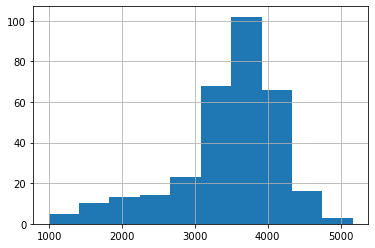

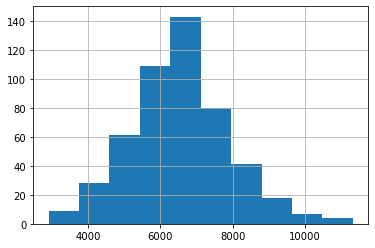

In [32]:
# the errors are also distributed differently if we split all ceo vs if we split pc
pc_split_results.error_for_confusion.hist()
plt.figure()
all_ceo_split_results.error_for_confusion.hist()

In [33]:
# car like ratio seems to matter in all cases.
# not a trip ratio's correlation is very different between pc and all ceo
# mispredicted as walk's correlation is very different between pc and all ceo. it is consistently large positive for different priors with all ceo
# drove alone to shared ride is negatively correlated in all cases, though very weak in all ceo and strong in pc and vail. 

In [34]:
ind_var_correlation_df_50_percent_ebike#.query('`p-value` < 0.01')  
# ebike ratio is negative here which makes sense because increasing the ebike percent means 
# that the data is closer to our assumption of 50% ebike. 

,Correlation,p-value
Independent Variable,,
drove_alone_2_shared_ride,-0.064344,1.508120e-01
no_sensed_ratio,0.191328,1.652124e-05
car_like_ratio,-0.578223,6.008958e-46
e_bike_ratio,-0.093613,3.638434e-02
not_a_trip_ratio,0.227941,2.575290e-07
car_like_as_not_car,-0.426875,1.462730e-23
e_bike_as_car,0.071938,1.081353e-01
e_bike_as_not_car_bike,-0.039840,3.740178e-01
non_car_2_car_user_label,-0.315397,5.201539e-13


Text(0, 0.5, 'EI divider')

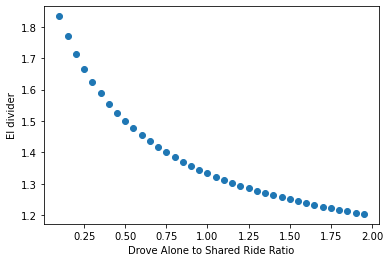

In [35]:
# what would I expect for the correlation between error and the dataset's drove alone to shared ride ratio, 
# given that I always assume that the ratio is 1:1?
r = np.arange(0.1,2,0.05)
car_load_factor = (r+1)/(r+0.5)    

plt.scatter(r,car_load_factor)
plt.xlabel("Drove Alone to Shared Ride Ratio")
plt.ylabel("EI divider")

# smaller car load factor (energy intensity divider) means that to minimize error, we should use an energy intensity closer to that of Gas Car, Drove Alone.
# As a reminder we actually use r = 1 and car_load_factor = 1.33.
# if the dataset r is below 1, that means there are fewer drove alones than we assumed. Most of the datasets have a smaller drove alone to shared ride ratio than 1. 
# (shared rides account for more distance traveled than drove alone)
# as r increases toward 1, we get closer to our assumption, so the error goes down.
# If the drove alone to shared ride is past 1 for the dataset, we are dividing by more than we need to so the gas car sensed EI 
# that we are using is smaller than it needs to be.

In [36]:
corrs_4c = get_splits_and_correlations(energy_consumption_df.query('program == "4c"'))

# we thought that this would happen but something else happened instead

Subset lengths: 527. Number of subsets: 500


In [37]:
corrs_4c

,Correlation,p-value
Independent Variable,,
drove_alone_2_shared_ride,-0.487167,3.666753e-31
no_sensed_ratio,-0.227953,2.571650e-07
car_like_ratio,0.024928,5.781406e-01
e_bike_ratio,0.304422,3.505470e-12
not_a_trip_ratio,0.079916,7.420178e-02
car_like_as_not_car,-0.297089,1.200359e-11
e_bike_as_car,0.215943,1.092631e-06
e_bike_as_not_car_bike,-0.098801,2.716518e-02
non_car_2_car_user_label,-0.403996,4.715356e-21


### How does dataset size (number of trips) relate to the percent error?
- split all ceo into subsets for 30 possible subset sizes.
- compute percent error for each.
- compute correlation.
- repeat? compute average of the correlations?
- try with a different prior? 

In [ ]:
n_trips_pct_error_corrs_list = []

for i in range(30):
    pct_error = []
    n_trips = []
    for j in reversed(range(34)):
        if j < 4: continue
        splits = hf.get_set_splits(energy_consumption_df, n_rounds=1, n_splits_per_round=j, print_info=False)
        sub_df = energy_consumption_df.loc[splits[0]]
        pct_error.append(100*hf.relative_error(sub_df.expected.sum(),sub_df.user_labeled.sum()))
        n_trips.append(len(sub_df))
    n_trips_pct_error_corrs_list.append(scipy.stats.pearsonr(np.array(pct_error),np.array(n_trips))[0])

In [ ]:
pct_error = []
n_trips = []
for i in range(40):
    for j in reversed(range(34)):
        if j < 4: continue
        splits = hf.get_set_splits(energy_consumption_df, n_rounds=1, n_splits_per_round=j, print_info=False)
        sub_df = energy_consumption_df.loc[splits[0]]
        pct_error.append(100*hf.relative_error(sub_df.expected.sum(),sub_df.user_labeled.sum()))
        n_trips.append(len(sub_df))
correlation = scipy.stats.pearsonr(np.array(pct_error),np.array(n_trips))[0]
print(correlation)